# ASTR 211 - HW03 - Sadie Seddon-Stettler

In [1]:
import numpy as np
 
import matplotlib.pyplot as plt
%matplotlib inline

from codes.plot_utils import plot_pretty
from codes.plot_utils import plot_histogram
from codes.plot_utils import plot_2d_dist
from codes.plot_utils import plot_line_points
from codes.plot_utils import plot_color_map
plot_pretty(fontsize=12)

from codes.histtools import shimazaki_shinomoto_rule
from codes.histtools import knuth_bin_width

from codes.read_data import read_jla_data

from codes.constants import clight

from codes.cosmology import d_L_romberg
from codes.cosmology import d_L_vectorized
from codes.cosmology import dl_func

from astropy.io import fits

from scipy import integrate
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import RectBivariateSpline
from scipy.special import erf

In [2]:
hdulist = fits.open('data/sdss_galaxies.fits') 
data = np.asarray(hdulist[1].data)

In [3]:
print(data.dtype)

(numpy.record, [('objid', '>i8'), ('ra', '>f8'), ('dec', '>f8'), ('g', '>f4'), ('r', '>f4'), ('z', '>f4')])


## Task 1a

In [4]:
zmin, zmax = 0.01, 0.14
rmin, rmax = 12, 17.77
isel = ((data['r'] > rmin) & (data['r'] < rmax) & (data['z'] > zmin) & (data['z'] < zmax))

In [5]:
mr = data['r'][isel]
gr = data['g'][isel] - data['r'][isel]
gr = gr[(gr > 0) & (gr < 1.3)]

In [6]:
print(np.size(gr))
print(gr.min(), gr.max())

48099
0.00013923645 1.2980251


Histogram with integer bins:

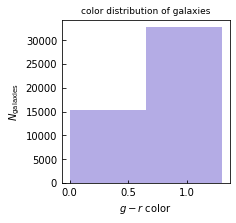

In [7]:
plot_histogram(gr, bins=2, xlabel=r'$g-r\ \rm color$', ylabel=r'$N_{\rm galaxies}$', 
               plot_title='color distribution of galaxies', figsize=3.0)

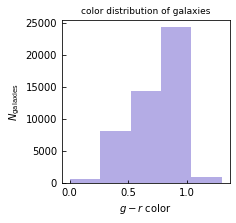

In [8]:
plot_histogram(gr, bins=5, xlabel=r'$g-r\ \rm color$', ylabel=r'$N_{\rm galaxies}$', 
               plot_title='color distribution of galaxies', figsize=3.0)

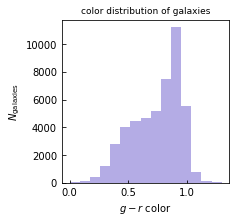

In [9]:
plot_histogram(gr, bins=15, xlabel=r'$g-r\ \rm color$', ylabel=r'$N_{\rm galaxies}$', 
               plot_title='color distribution of galaxies', figsize=3.0)

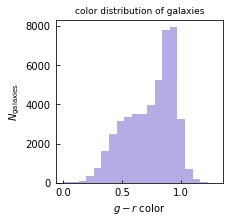

In [10]:
plot_histogram(gr, bins=20, xlabel=r'$g-r\ \rm color$', ylabel=r'$N_{\rm galaxies}$', 
               plot_title='color distribution of galaxies', figsize=3.0)

Filtering to only values between 0 and 2 allows us to see the distribution much more clearly. Then, changing the number of bins allows us to see the shape of the distribution much more clearly - what is simply a lopsided peak at 2 or 5 bins turns into an interesting shape at 15 or 20 bins.

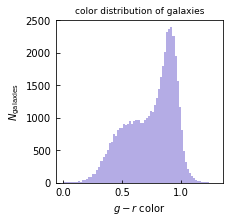

In [11]:
plot_histogram(gr, bins='auto', xlabel=r'$g-r\ \rm color$', ylabel=r'$N_{\rm galaxies}$', 
               plot_title='color distribution of galaxies', figsize=3.0)

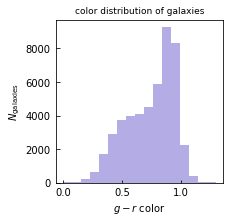

In [12]:
plot_histogram(gr, bins='sturges', xlabel=r'$g-r\ \rm color$', ylabel=r'$N_{\rm galaxies}$', 
               plot_title='color distribution of galaxies', figsize=3.0)

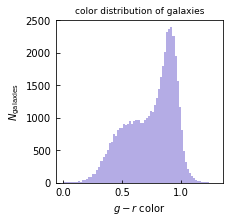

In [13]:
plot_histogram(gr, bins='fd', xlabel=r'$g-r\ \rm color$', ylabel=r'$N_{\rm galaxies}$', 
               plot_title='color distribution of galaxies', figsize=3.0)

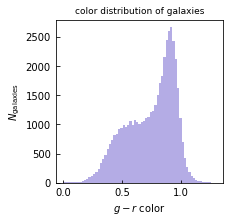

In [14]:
plot_histogram(gr, bins='scott', xlabel=r'$g-r\ \rm color$', ylabel=r'$N_{\rm galaxies}$', 
               plot_title='color distribution of galaxies', figsize=3.0)

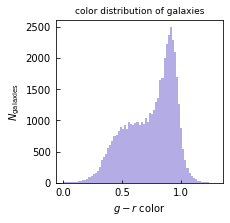

In [15]:
plot_histogram(gr, bins='rice', xlabel=r'$g-r\ \rm color$', ylabel=r'$N_{\rm galaxies}$', 
               plot_title='color distribution of galaxies', figsize=3.0)

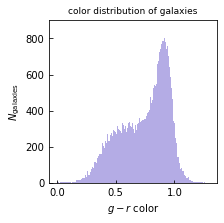

In [16]:
plot_histogram(gr, bins='sqrt', xlabel=r'$g-r\ \rm color$', ylabel=r'$N_{\rm galaxies}$', 
               plot_title='color distribution of galaxies', figsize=3.0)

Again we see that the type of bins used changes the shape of the distribution, but this time much less drastically. All of the choices produce this similar two-peaked shape, but with different levels of noise. 'sturges' produces a very chunky plot, with few bins, whereas 'sqrt' produces a plot with many many small fluctuations visible. 'rice', 'scott', 'fd', and 'auto' all produce fairly similar looking distributions.

## Task 1b

In [17]:
zmin, zmax = 0.01, 0.14
rmin, rmax = 12, 17.77
isel = ((data['r'] > rmin) & (data['r'] < rmax) & (data['z'] > zmin) & (data['z'] < zmax))

mr = data['r'][isel]
gr = data['g'][isel] - data['r'][isel]
mr = mr[(gr > 0) & (gr < 1.3)]
gr = gr[(gr > 0) & (gr < 1.3)]

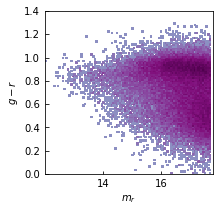

In [18]:
plot_2d_dist(mr, gr, xlim=[mr.min(), mr.max()], ylim=[0, 1.4],
             nxbins=100, nybins=100, 
             xlabel=r'$m_r$', ylabel=r'$g-r$', figsize=(3,3))

In [19]:
zmin, zmax = 0.01, 0.05
rmin, rmax = 15, 17
isel = ((data['r'] > rmin) & (data['r'] < rmax) & (data['z'] > zmin) & (data['z'] < zmax))

mr = data['r'][isel]
gr = data['g'][isel] - data['r'][isel]
mr = mr[(gr > 0) & (gr < 1.3)]
gr = gr[(gr > 0) & (gr < 1.3)]

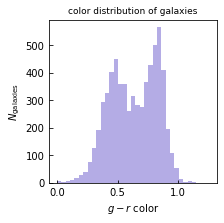

In [20]:
plot_histogram(gr, bins='scott', xlabel=r'$g-r\ \rm color$', ylabel=r'$N_{\rm galaxies}$', 
               plot_title='color distribution of galaxies', figsize=3.0)

For (0.01 < z < 0.05) and (15 < r < 17) we can see a new shape emerge, of a two-peaked distribution. (You can narrow r as well, but it makes the bins wider and thus harder to see the two peaks). Examining the 2D histogram mesh distribution gives us some insight as to why - when mr gets far enough to the right (nearer to 16 or 17), there is visible a 2-peak shape (the two areas of darker purple color). Then it's just a matter of tuning the z value to make that distribution visible, and narrowing it to 0.03 plus or minus 0.02 narrows it enough for us to see the two-peak shape.

## Task 1c

In [21]:
nss, hss = shimazaki_shinomoto_rule(gr, Nbmin=4, Nbmax=500)
print("number of bins according to Shimazaki-Shinomoto method is %d"%nss)

number of bins according to Shimazaki-Shinomoto method is 55


In [22]:
h_knuth, bins_knuth = knuth_bin_width(gr, return_bins=True)
n_knuth = np.shape(bins_knuth)[0] - 1
print("number of bins according to Knuth method is %d"%n_knuth)

Optimization terminated successfully.
         Current function value: -3407.894370
         Iterations: 16
         Function evaluations: 47
number of bins according to Knuth method is 37


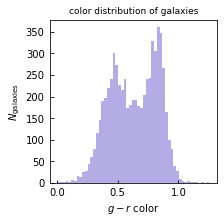

In [23]:
plot_histogram(gr, bins=nss, xlabel=r'$g-r\ \rm color$', ylabel=r'$N_{\rm galaxies}$', 
               plot_title='color distribution of galaxies', figsize=3.0)

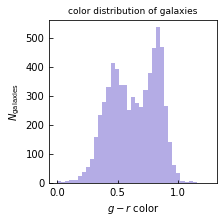

In [24]:
plot_histogram(gr, bins=n_knuth, xlabel=r'$g-r\ \rm color$', ylabel=r'$N_{\rm galaxies}$', 
               plot_title='color distribution of galaxies', figsize=3.0)

For the same subsection of z and r values, using Knuth and Shimazaki-Shinomoto methods still show the two-peak distribution, looking almost identical to the scott binning method. Which is interesting, given that the number of bins calculated by Shimazaki-Shinomoto is 55 and Knuth is 37. This suggests to me that, at least for (0.01 < z < 0.05) and (15 < r < 17), the two-peak structure is actually real.

## Task 1d

For a 2d distribution, it is an unreasonable assumption that either of the axes will be a normal distribution - or at the least, the assumption of a normal distribution will throw us off greatly if we are wrong. We will also consider each axis as a separate distribution - it is safer to bin as if the two are not related, and apply the same binning method to both. I would like to avoid the slow growth of the Sturges and Rice rules, but I would like to adjust for some type of data spread. My heuristic method, which I am dubbing FDR, is a combination of the Freedman-Daconis and Square Root heuristic rules, and its calculated bin width scales with IQR and the square root of N:

$$h_{FDSR} = \frac{2IQR(x)}{\sqrt{N}}$$

In [25]:
def FDR_bins(x):
    max_min = x.max() - x.min()
    iqr = np.subtract(*np.percentile(x, [75, 25]))
    bin_width = 2.0 * iqr * x.size ** (-1.0 / 2)
    return int(max_min // bin_width)

In [26]:
n_FDR = FDR_bins(gr)

Use those calculated bins to plot the 1d and 2d histograms! Let's first plot zoomed in on the two-peak part of the distribution:

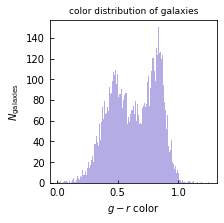

In [27]:
plot_histogram(gr, bins=n_FDR, xlabel=r'$g-r\ \rm color$', ylabel=r'$N_{\rm galaxies}$', 
               plot_title='color distribution of galaxies', figsize=3.0)

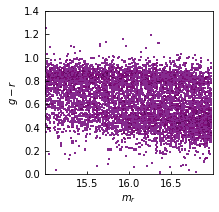

In [28]:
plot_2d_dist(mr, gr, xlim=[mr.min(), mr.max()], ylim=[0, 1.4],
             nxbins=n_FDR, nybins=n_FDR, 
             xlabel=r'$m_r$', ylabel=r'$g-r$', figsize=(3,3))

Or, we can take a look at how this binning method does overall:

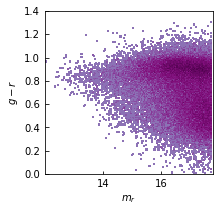

In [29]:
zmin, zmax = 0.01, 0.14
rmin, rmax = 12, 17.77
isel = ((data['r'] > rmin) & (data['r'] < rmax) & (data['z'] > zmin) & (data['z'] < zmax))

mr = data['r'][isel]
gr = data['g'][isel] - data['r'][isel]
mr = mr[(gr > 0) & (gr < 1.3)]
gr = gr[(gr > 0) & (gr < 1.3)]

plot_2d_dist(mr, gr, xlim=[mr.min(), mr.max()], ylim=[0, 1.4],
             nxbins=n_FDR, nybins=n_FDR, 
             xlabel=r'$m_r$', ylabel=r'$g-r$', figsize=(3,3))

## Task 2a

In [4]:
zCMB, mB, emB = read_jla_data(sn_list_name = 'data/jla_lcparams.txt')
print("read sample of %d supernovae..."%(np.size(zCMB)))

read sample of 740 supernovae...


For simplicity's sake, copy in our code from exercise 2 of HW2 to use here:

In [5]:
def chebyshev_nodes1(a, b, N):
    nodes = a + 0.5*(b-a)*(1. + np.cos((2.*np.arange(N+0)+1)*np.pi/(2.*(N+0))))
    nodes = nodes[::-1]
    return nodes

In [6]:
ntrain = 10

Om0min, Om0max = 0., 1
OmLmin, OmLmax = 0., 1
Om0tr = chebyshev_nodes1(Om0min, Om0max, ntrain)
OmLtr = chebyshev_nodes1(OmLmin, OmLmax, ntrain)
d_L_train = np.zeros((ntrain, ntrain))

def tilde_d_L(Om0, OmL, z):
    for i, Omd in enumerate(Om0):
        for j, Omld in enumerate(OmL):
                d_L_train[i][j] = 70 / clight * d_L_vectorized(z, 70, Omd, Omld, atol=5.e-16, rtol=5.e-16)

    spl2d = RectBivariateSpline(Om0, OmL, d_L_train, s=0, kx=3, ky=3)
    
    return spl2d

In [7]:
nOm0, nOmL = np.size(Om0tr), np.size(OmLtr)
ntrx, ntry = nOm0, nOmL

dLz = []

for iz, zi in enumerate(zCMB):
    d_l_spl = tilde_d_L(Om0tr, OmLtr, zi)
    dLz.append(d_l_spl)

In [14]:
def chi2(Omega0, OmegaL, tM0):
    chi2_z = np.empty(np.size(zCMB))
    for iz, zi in enumerate(zCMB):
        print("NEW LOOP")
        print("zi:", zi)
        spline = dLz[iz]
        print("spline:", spline)
        d_L = spline(Omega0, OmegaL)[0][0]
        print("d_L:", d_L)
        print("mb, 5log10(d_L), emB:", mB[iz], 5*np.log10(d_L), emB[iz])
        chi2_z[iz] = ((mB[iz] - 5*np.log10(d_L) - tM0) ** 2) / (emB[iz] ** 2)
        print("chi2_z[iz]:", chi2_z[iz])
        
    chi2 = np.sum(chi2_z)
    
    return chi2

In [15]:
print(chi2(0.9, 0.9, -19.1))

NEW LOOP
zi: 0.503084
spline: <scipy.interpolate.fitpack2.RectBivariateSpline object at 0x0000011B4507C148>
d_L: 0.6214194766623301
mb, 5log10(d_L), emB: 23.001698 -1.033075695585309 0.088031
chi2_z[iz]: 240095.36553762126
NEW LOOP
zi: 0.580724
spline: <scipy.interpolate.fitpack2.RectBivariateSpline object at 0x0000011B45092B48>
d_L: 0.7280526774875403
mb, 5log10(d_L), emB: 23.573937 -0.689185983142925 0.090132
chi2_z[iz]: 231463.80516236782
NEW LOOP
zi: 0.494795
spline: <scipy.interpolate.fitpack2.RectBivariateSpline object at 0x0000011B44E9F6C8>
d_L: 0.6101033227209636
mb, 5log10(d_L), emB: 22.960139 -1.0729830488173622 0.08811
chi2_z[iz]: 239646.6630368233
NEW LOOP
zi: 0.345928
spline: <scipy.interpolate.fitpack2.RectBivariateSpline object at 0x0000011B4507C188>
d_L: 0.4102879283716469
mb, 5log10(d_L), emB: 22.398137 -1.9345563040114757 0.087263
chi2_z[iz]: 247726.94308967204
NEW LOOP
zi: 0.677662
spline: <scipy.interpolate.fitpack2.RectBivariateSpline object at 0x0000011B4507C288>


chi2_z[iz]: 134653.14086863663
NEW LOOP
zi: 0.11771
spline: <scipy.interpolate.fitpack2.RectBivariateSpline object at 0x0000011B41B58488>
d_L: 0.1268253820641394
mb, 5log10(d_L), emB: 19.052211 -4.483969103436488 0.11196
chi2_z[iz]: 145020.96696772616
NEW LOOP
zi: 0.21971
spline: <scipy.interpolate.fitpack2.RectBivariateSpline object at 0x0000011B41B78EC8>
d_L: 0.24876775446555163
mb, 5log10(d_L), emB: 20.855502 -3.021029570172332 0.115514
chi2_z[iz]: 138418.2900561828
NEW LOOP
zi: 0.14901
spline: <scipy.interpolate.fitpack2.RectBivariateSpline object at 0x0000011B41B78D48>
d_L: 0.16322961239919093
mb, 5log10(d_L), emB: 19.972155 -3.936005253188174 0.112283
chi2_z[iz]: 146714.72879783553
NEW LOOP
zi: 0.28742
spline: <scipy.interpolate.fitpack2.RectBivariateSpline object at 0x0000011B41B78E48>
d_L: 0.3342398215710286
mb, 5log10(d_L), emB: 21.262819 -2.379709046026863 0.118845
chi2_z[iz]: 129347.661281867
NEW LOOP
zi: 0.1436
spline: <scipy.interpolate.fitpack2.RectBivariateSpline object 

zi: 0.935774
spline: <scipy.interpolate.fitpack2.RectBivariateSpline object at 0x0000011B450EB6C8>
d_L: 1.2215598726372032
mb, 5log10(d_L), emB: 24.481915 0.4345737901073013 0.119916
chi2_z[iz]: 129465.42798632289
NEW LOOP
zi: 0.049519
spline: <scipy.interpolate.fitpack2.RectBivariateSpline object at 0x0000011B450EB708>
d_L: 0.051227160797269716
mb, 5log10(d_L), emB: 17.762489 -6.452498568485588 0.139446
chi2_z[iz]: 96485.99194046757
NEW LOOP
zi: 0.030325
spline: <scipy.interpolate.fitpack2.RectBivariateSpline object at 0x0000011B450EB748>
d_L: 0.030975712568850084
mb, 5log10(d_L), emB: 16.239518 -7.5448934713841815 0.143169
chi2_z[iz]: 89722.40900622802
NEW LOOP
zi: 0.074579
spline: <scipy.interpolate.fitpack2.RectBivariateSpline object at 0x0000011B450EB788>
d_L: 0.0783739352516998
mb, 5log10(d_L), emB: 18.465664 -5.52914173112208 0.141947
chi2_z[iz]: 92171.66187003681
NEW LOOP
zi: 0.025198
spline: <scipy.interpolate.fitpack2.RectBivariateSpline object at 0x0000011B450EB7C8>
d_L: 0.0

## Task 2b

## Task 2c

## Task 2d